# Stories

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import re
import logging

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

from time import time

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, TimestampType

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.metrics.metrics import Metrics
from sponge_bob_magic.validation_schemes import ValidationSchemes

In [5]:
# Отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [24]:
spark_memory = "256g"
spark_cores = "20"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .config('spark.local.dir', "/datascc/aysina-rm/code/sponge-bob-magic/data/tmp")
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

In [25]:
# spark.stop()

In [26]:
spark

In [27]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [28]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Основные данные и пути

In [29]:
path_data = '/datascc/share/stories_data'
path_log = path_data
path_checkpoints = '../data/checkpoints'

In [30]:
spark.sparkContext.setCheckpointDir(path_checkpoints)

## Подготовка данных

In [31]:
dp = DataPreparator(spark)

In [32]:
df = dp.transform_log(
    path=path_log,
    format_type="csv",
    columns_names={
        "user_id": "_c1",
        "item_id": "_c2",
        "timestamp": "_c0",
        "relevance": "_c3"
    }
).cache()

In [33]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- relevance: float (nullable = true)
 |-- context: string (nullable = false)



In [34]:
df.show(3)

+---------+-------+-------------------+---------+----------+
|  user_id|item_id|          timestamp|relevance|   context|
+---------+-------+-------------------+---------+----------+
|111715824|   1174|2019-07-19 00:00:00|   2896.0|no_context|
|430734041|  12093|2019-07-19 00:00:00|   4073.0|no_context|
|150084873|  12093|2019-07-19 00:00:00|  16462.0|no_context|
+---------+-------+-------------------+---------+----------+
only showing top 3 rows



In [35]:
# df.checkpoint()

In [36]:
# df.count()

## Рекомендации популярных объектов

In [37]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [38]:
%%time

pr.fit(
    log=df,
    user_features=None,
    item_features=None,
    path=None
)

16-Oct-19 15:51:29, root, DEBUG: Среднее количество items у каждого user: 5.0
16-Oct-19 15:51:29, root, DEBUG: Среднее количество items у каждого user: 5.0


CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 55.3 s


In [39]:
%%time

recs = pr.predict(
    k=100,
    users=None,
    items=None,
    context='no_context',
    log=df,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
)

16-Oct-19 15:51:31, root, DEBUG: Проверка датафреймов
16-Oct-19 15:51:31, root, DEBUG: Проверка датафреймов
16-Oct-19 15:51:32, root, DEBUG: Выделение дефолтных юзеров
16-Oct-19 15:51:32, root, DEBUG: Выделение дефолтных юзеров
16-Oct-19 15:51:32, root, DEBUG: Выделение дефолтных айтемов
16-Oct-19 15:51:32, root, DEBUG: Выделение дефолтных айтемов
16-Oct-19 15:51:38, root, DEBUG: Количество items после фильтрации: 105
16-Oct-19 15:51:38, root, DEBUG: Количество items после фильтрации: 105
16-Oct-19 15:51:54, root, DEBUG: Длина recs: 1542589230
16-Oct-19 15:51:54, root, DEBUG: Длина recs: 1542589230


CPU times: user 180 ms, sys: 36 ms, total: 216 ms
Wall time: 19min 20s


In [40]:
recs.show(5)

+-------+---------+----------+--------------------+
|item_id|  user_id|   context|           relevance|
+-------+---------+----------+--------------------+
|   1040|100000982|no_context|0.013188825045425694|
|  12093|100000982|no_context| 0.01307344864269448|
|  12087|100000982|no_context|0.012356258171948098|
|  12233|100000982|no_context|0.010991035103668301|
|  12299|100000982|no_context|0.010948755653370359|
+-------+---------+----------+--------------------+
only showing top 5 rows



In [41]:
%%time

metric = Metrics.hit_rate_at_k(recs, df, k=100)
metric

CPU times: user 188 ms, sys: 52 ms, total: 240 ms
Wall time: 28min 11s


0.09669310993439258

## Сценарий с популярной моделью

In [ ]:
df_short = df.limit(10)
df_short.checkpoint()

In [42]:
avg_num_users = (
    df
    .select('user_id', 'item_id')
    .groupBy('item_id')
    .count()
    .select(sf.mean(sf.col('count')).alias('mean'))
    .collect()[0]['mean']
)

avg_num_users

44799.95916955017

In [43]:
popular_scenario = PopularScenario(spark)
popular_params_grid = {'alpha': (0, 40000), 'beta': (0, 40000)}
# popular_scenario.seed = 9876

In [44]:
%%time

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=15, context='no_context',
    to_filter_seen_items=True,
    n_trials=3, n_jobs=1,
    how_to_split='randomly'
)

16-Oct-19 16:59:55, root, DEBUG: Деление на трейн и тест
16-Oct-19 16:59:55, root, DEBUG: Деление на трейн и тест
16-Oct-19 17:01:12, root, DEBUG: Размер трейна:      45316688
16-Oct-19 17:01:12, root, DEBUG: Размер трейна:      45316688
16-Oct-19 17:01:19, root, DEBUG: Размер теста_инпут: 45316688
16-Oct-19 17:01:19, root, DEBUG: Размер теста_инпут: 45316688
16-Oct-19 17:01:33, root, DEBUG: Размер теста:       19419224
16-Oct-19 17:01:33, root, DEBUG: Размер теста:       19419224
16-Oct-19 17:02:52, root, DEBUG: Среднее количество items у каждого user: 4.0
16-Oct-19 17:02:52, root, DEBUG: Среднее количество items у каждого user: 4.0
16-Oct-19 17:03:01, root, DEBUG: Начало оптимизации параметров
16-Oct-19 17:03:01, root, DEBUG: Начало оптимизации параметров
16-Oct-19 17:03:01, root, DEBUG: Предикт модели в оптимизации
16-Oct-19 17:03:01, root, DEBUG: Предикт модели в оптимизации
16-Oct-19 17:03:01, root, DEBUG: Проверка датафреймов
16-Oct-19 17:03:01, root, DEBUG: Проверка датафреймов


CPU times: user 572 ms, sys: 116 ms, total: 688 ms
Wall time: 26min


In [45]:
best_params

{'alpha': 11011, 'beta': 11537}

In [46]:
results = popular_scenario.study.trials_dataframe()

results.head()

number                state     value             datetime_start  \
                                                                     
0  0      TrialState.COMPLETE  0.014707 2019-10-16 17:03:01.435110   
1  1      TrialState.COMPLETE  0.014707 2019-10-16 17:10:44.108308   
2  2      TrialState.COMPLETE  0.014707 2019-10-16 17:18:18.816379   

           datetime_complete params         user_attrs system_attrs  
                              alpha   beta some_metric      _number  
0 2019-10-16 17:10:44.105755  11011  11537  1.0         0            
1 2019-10-16 17:18:18.813698  8208   35267  1.0         1            
2 2019-10-16 17:25:55.886147  10899  20630  1.0         2

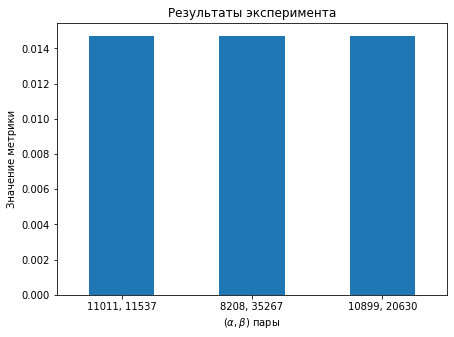

In [49]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты эксперимента')

    plt.show()
    

plot_result_value(results)

In [48]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

16-Oct-19 17:32:40, root, DEBUG: Среднее количество items у каждого user: 5.0
16-Oct-19 17:32:40, root, DEBUG: Среднее количество items у каждого user: 5.0
16-Oct-19 17:32:42, root, DEBUG: Проверка датафреймов
16-Oct-19 17:32:42, root, DEBUG: Проверка датафреймов
16-Oct-19 17:32:42, root, DEBUG: Выделение дефолтных юзеров
16-Oct-19 17:32:42, root, DEBUG: Выделение дефолтных юзеров
16-Oct-19 17:32:42, root, DEBUG: Выделение дефолтных айтемов
16-Oct-19 17:32:42, root, DEBUG: Выделение дефолтных айтемов
16-Oct-19 17:32:51, root, DEBUG: Количество items после фильтрации: 15
16-Oct-19 17:32:51, root, DEBUG: Количество items после фильтрации: 15
16-Oct-19 17:33:02, root, DEBUG: Длина recs: 220369890
16-Oct-19 17:33:02, root, DEBUG: Длина recs: 220369890


CPU times: user 68 ms, sys: 16 ms, total: 84 ms
Wall time: 3min 9s


In [50]:
best_recs.show(10)

+-------+---------+----------+--------------------+
|item_id|  user_id|   context|           relevance|
+-------+---------+----------+--------------------+
|   1040|100000982|no_context| 0.01335653567850164|
|  12093|100000982|no_context|0.013241179834062417|
|  12087|100000982|no_context| 0.01252411715557477|
|  12233|100000982|no_context| 0.01115913734894817|
|  12299|100000982|no_context|0.011116865432194903|
|   1066|100000982|no_context|0.010584304148495174|
|   1075|100000982|no_context|0.008571746995303817|
|  12180|100000982|no_context|0.008538108619458506|
|   1034|100000982|no_context|0.008167684925117855|
|  12542|100000982|no_context|0.007929374484671048|
+-------+---------+----------+--------------------+
only showing top 10 rows



In [51]:
spark.stop()